In [7]:
## Parser logic, you can safely ignore this

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
from math import nan, isnan, ceil
import networkx as nx
import re
import statistics
import tabulate
import numpy as np
import pandas as pd

def get_offsets(num_elements: int):
    if (num_elements % 2 == 0):
        half_ne = num_elements/2
        minus_range = np.arange(-half_ne, 0)
        plus_range = np.arange(1, half_ne+1)
        return np.append(minus_range, plus_range)/num_elements
    else:
        half_ne = floor(num_elements/2)
        minus_range = np.arange(-half_ne, 1)
        plus_range = np.arange(1, half_ne+1)
        return np.append(minus_range, plus_range)/num_elements

def self_histogram(values: list, normalized: bool = True) -> dict:
    histo_dkt = {}
    for val in values:
        histo_dkt[val] = histo_dkt.get(val, 0)+1
    if normalized:
        for val in histo_dkt:
            histo_dkt[val] = histo_dkt[val]*100/len(values)
    return histo_dkt

def get_info_category() -> dict:
    return {'padec.attribute.SoundLevel': 1,'padec.attribute.Identity': 3, 'padec.attribute.Location': 2}

def parse_info(info: str) -> tuple:
    categories = get_info_category()
    parsed = re.search(
        "(padec.attribute.[a-zA-Z]*|History \(precision [-]?[0-9]*[\.]?[0-9Ee]+\)) from ([^,]*)", info)
    info_type = parsed.group(1)
    host = parsed.group(2)
    if info_type not in categories:
        precision_parsed = re.search("precision ([-]?[0-9]*[\.]?[0-9Ee]+)", info_type)
        if precision_parsed is not None:
            prec_info_type = re.sub(" \(precision [-]?[0-9]*[\.]?[0-9Ee]+\)", "", info_type)
            precision = precision_parsed.group(1)
            return ('Precision', prec_info_type, float(precision), host)
    else:
        return ('Category', info_type, float(categories[info_type]), host)

def read_report(report_file: str):
    g = nx.Graph()
    with open(report_file, 'r') as in_report:
        rep_lines = list(map(lambda x: x.rstrip('\n'), in_report.readlines()))
    rep_lines = rep_lines[2:] # Remove headers
    rep_lines = list(filter(lambda x: x!='', rep_lines)) # Remove empty lines
    for line in rep_lines:
        inf_re = re.search(": \[([^\]]*)\]", line)
        if inf_re is not None:
            infos = inf_re.group(1)
            if infos != '':
                party = re.sub(": \[[^\]]*\]", "", line)
                parsed_infos = list(map(lambda x: parse_info(x), infos.split(", ")))
                if not g.has_node(party):
                    g.add_node(party)
                for p_info in parsed_infos:
                    if p_info[0] == 'Category':
                        if not g.has_edge(party, p_info[3]):
                            g.add_edge(party, p_info[3], category=p_info[2], n_infos=1, sum_cat=p_info[2])
                        else:
                            if g.edges[party, p_info[3]]['category'] < p_info[2]:
                                g.edges[party, p_info[3]]['category'] = p_info[2]
                            g.edges[party, p_info[3]]['n_infos'] += 1
                            g.edges[party, p_info[3]]['sum_cat'] += p_info[2]
                    else:
                        if g.nodes[party].get('precision') is None:
                            g.nodes[party]['precision'] = p_info[2]
                        else:
                            if g.nodes[party]['precision'] > p_info[2]:
                                g.nodes[party]['precision'] = p_info[2]
    return g

def get_max_val() -> float:
    return 1e3

def scale(nums: list) -> list:
    return list(map(lambda x: (x*100)/get_max_val() if x >= -1 else 500, nums))

def def_val(x: str) -> list:
    if x.startswith('C'):
        return 1
    else:
        return 2
    
def generate_legend_artist(color: str, label: str):
    return mpatches.Patch(color=color, label=label)

def draw_graph(g, limits: tuple = None, output: str = None):
    node_vals = [-1*g.nodes[x].get('precision', def_val(x)) for x in g.nodes]
    mv = get_max_val()
    node_vals = [v if v <= mv else mv for v in node_vals]
    node_vals = scale(node_vals)
    vmin = 0
    vmax = 100
    edge_vals = [g.edges[e]['category'] for e in g.edges]
    edge_vmin = 0
    edge_vmax = 3
    jet = get_cmap('jet')
    jet.set_under('black')
    jet.set_over('gray')
    viridis = get_cmap('viridis')
    nx.draw_networkx(g, with_labels=False, cmap=jet, edge_cmap=viridis, node_color=node_vals, vmin=vmin, vmax=vmax, edge_color=edge_vals, edge_vmax=edge_vmax, edge_vmin=edge_vmin)
    clb1 = plt.colorbar(ScalarMappable(Normalize(vmin, vmax), jet))
    clb1.set_label('Maximum endpoint precision (%)')
    clb2 = plt.colorbar(ScalarMappable(Normalize(edge_vmin, edge_vmax), viridis))
    clb2.set_label('Maximum revealed category')
    plt.legend(handles=[generate_legend_artist('grey', 'Provider'), generate_legend_artist('black', 'Denied access')])
    plt.tight_layout()
    if output is not None:
        if output.endswith('.eps'):
            plt.savefig(output, format='eps')
        else:
            plt.savefig(output)
    plt.show()

def draw_graph_2(reports: list, report_labels: list, limits: tuple = None, output: str = None):
    data_dkt = {'Average precision': [], 
                'Average category': [], 
                'Denied accesses': [], 
                'Average attributes per key': []}
    markers = ['o', 'x', 's', 'P', '*', 'd', 'X', 'p']
    for rep in reports:
        g = read_report(rep)
        node_vals = [-1*g.nodes[x].get('precision', def_val(x)) for x in g.nodes]
        mv = get_max_val()
        node_vals = [v if v <= mv else mv for v in node_vals]
        node_vals = scale(node_vals)
        denied_accesses = len(list(filter(lambda x: x < 0, node_vals)))*100/len(node_vals)
        node_vals = list(filter(lambda x: x>=0 and x<=100, node_vals))
        edge_vals = [g.edges[e]['category'] for e in g.edges]
        categories = [x*100/3 for x in edge_vals]
        infos = [g.edges[e]['n_infos'] for e in g.edges]
        infos = [x*100/3 for x in infos]
        data_dkt['Average precision'].append(statistics.mean(node_vals))
        data_dkt['Average category'].append(statistics.mean(categories))
        data_dkt['Denied accesses'].append(denied_accesses)
        data_dkt['Average attributes per key'].append(statistics.mean(infos))
    for key, marker in zip(data_dkt, markers):
        plt.plot(list(range(len(data_dkt[key]))), data_dkt[key], marker=marker, linestyle='solid', label=key)
    plt.xticks(ticks=list(range(len(data_dkt['Average precision']))), labels=report_labels)
    plt.legend()
    plt.tight_layout(pad=0)
    plt.show()
    
def column_chart(reports: list, report_labels: list, limits: tuple = None, output: str = None, bar_width: float = 0.15):
    data_dkt = {'Provider privacy': [], 
                'Consumer privacy': [], 
                'Denied accesses': [], 
                'Authorization request size': [],
                'Messages per request': []}
    for rep_ndx, rep in enumerate(reports):
        g = read_report(rep)
        node_vals = [-1*g.nodes[x].get('precision', def_val(x)) for x in g.nodes]
        mv = get_max_val()
        node_vals = [v if v <= mv else mv for v in node_vals]
        node_vals = scale(node_vals)
        denied_accesses = len(list(filter(lambda x: x < 0, node_vals)))*100/len(node_vals)
        node_vals = list(filter(lambda x: x>=0 and x<=100, node_vals))
        edge_vals = [g.edges[e]['category'] for e in g.edges]
        categories = [x*100/3 for x in edge_vals]
        infos = [g.edges[e]['n_infos'] for e in g.edges]
        infos = [x*100/3 for x in infos]
        data_dkt['Provider privacy'].append(100 - statistics.mean(node_vals))
        data_dkt['Consumer privacy'].append(100 - statistics.mean(categories))
        data_dkt['Denied accesses'].append(denied_accesses)
        data_dkt['Authorization request size'].append(statistics.mean(infos))
        if rep_ndx <= 1:
            data_dkt['Messages per request'].append(50)
        else:
            data_dkt['Messages per request'].append(100)
    
    proxy_df = pd.DataFrame([(key, 'Step {}'.format(ndx+1), element) for key in data_dkt for ndx, element in enumerate(data_dkt[key])], columns = ['Metric', 'Step', 'Value'])
    proxy_df.pivot("Step", "Metric", "Value").plot(kind='bar')
    plt.xlabel('')
    plt.ylabel('Normalized metric value (%)')
    plt.legend(bbox_to_anchor=(0.8, -0.2), ncol=2)
    plt.tight_layout(pad=0)
    plt.show()

def col_chart_privacy(reports: list, report_labels: list, limits: tuple = None, output: str = None, bar_width: float = 0.15):
    data_dkt = {'Provider privacy': [], 
                'Consumer privacy': [], 
                'Denied accesses': []}
    for rep_ndx, rep in enumerate(reports):
        g = read_report(rep)
        node_vals = [-1*g.nodes[x].get('precision', def_val(x)) for x in g.nodes]
        mv = get_max_val()
        node_vals = [v if v <= mv else mv for v in node_vals]
        node_vals = scale(node_vals)
        denied_accesses = len(list(filter(lambda x: x < 0, node_vals)))*100/len(node_vals)
        node_vals = list(filter(lambda x: x>=0 and x<=100, node_vals))
        edge_vals = [g.edges[e]['category'] for e in g.edges]
        categories = [x*100/3 for x in edge_vals]
        infos = [g.edges[e]['n_infos'] for e in g.edges]
        infos = [x*100/3 for x in infos]
        data_dkt['Provider privacy'].append(100 - statistics.mean(node_vals))
        data_dkt['Consumer privacy'].append(100 - statistics.mean(categories))
        data_dkt['Denied accesses'].append(denied_accesses)
    proxy_df = pd.DataFrame([(key, 'Step {}'.format(ndx+1), element) for key in data_dkt for ndx, element in enumerate(data_dkt[key])], columns = ['Metric', 'Step', 'Value'])
    proxy_df.pivot("Step", "Metric", "Value").plot(kind='bar')
    plt.xlabel('')
    plt.ylabel('Normalized metric value (%)')
    plt.legend(bbox_to_anchor=(0.8, -0.2), ncol=2)
    plt.tight_layout(pad=0)
    plt.show()

def col_chart_privacy_weighted(reports: list, report_labels: list, limits: tuple = None, output: str = None, bar_width: float = 0.15):
    data_dkt = {'Provider privacy': [], 
                'Consumer privacy': [], 
                'Denied accesses': []}
    for rep_ndx, rep in enumerate(reports):
        g = read_report(rep)
        node_vals = [-1*g.nodes[x].get('precision', def_val(x)) for x in g.nodes]
        mv = get_max_val()
        node_vals = [v if v <= mv else mv for v in node_vals]
        node_vals = scale(node_vals)
        denied_accesses = len(list(filter(lambda x: x < 0, node_vals)))*100/len(node_vals)
        node_vals = list(filter(lambda x: x>=0 and x<=100, node_vals))
        edge_vals = [g.edges[e]['category'] for e in g.edges]
        sum_cats = [g.edges[e]['sum_cat'] for e in g.edges]
        sum_cats = [x*100/6 for x in sum_cats]
        categories = [x*100/3 for x in edge_vals]
        infos = [g.edges[e]['n_infos'] for e in g.edges]
        infos = [x*100/3 for x in infos]
        data_dkt['Provider privacy'].append(100 - statistics.mean(node_vals))
        data_dkt['Consumer privacy'].append(100 - statistics.mean(sum_cats))
        data_dkt['Denied accesses'].append(denied_accesses)
    proxy_df = pd.DataFrame([(key, 'Step {}'.format(ndx+1), element) for key in data_dkt for ndx, element in enumerate(data_dkt[key])], columns = ['Metric', 'Step', 'Value'])
    proxy_df.pivot("Step", "Metric", "Value").plot(kind='bar')
    plt.xlabel('')
    plt.ylabel('Normalized metric value (%)')
    plt.legend(bbox_to_anchor=(0.8, -0.2), ncol=2)
    plt.tight_layout(pad=0)
    plt.show()
    
def col_chart_privacy_usefulness(reports: list, report_labels: list, limits: tuple = None, output: str = None, bar_width: float = 0.15):
    data_dkt = {'Provider privacy': [], 
                'Consumer privacy': [], 
                'Successful accesses': []}
    for rep_ndx, rep in enumerate(reports):
        g = read_report(rep)
        node_vals = [-1*g.nodes[x].get('precision', def_val(x)) for x in g.nodes]
        mv = get_max_val()
        node_vals = [v if v <= mv else mv for v in node_vals]
        node_vals = scale(node_vals)
        denied_accesses = len(list(filter(lambda x: x < 0, node_vals)))*100/len(node_vals)
        node_vals = list(filter(lambda x: x>=0 and x<=100, node_vals))
        edge_vals = [g.edges[e]['category'] for e in g.edges]
        sum_cats = [g.edges[e]['sum_cat'] for e in g.edges]
        sum_cats = [x*100/6 for x in sum_cats]
        categories = [x*100/3 for x in edge_vals]
        infos = [g.edges[e]['n_infos'] for e in g.edges]
        infos = [x*100/3 for x in infos]
        data_dkt['Provider privacy'].append(100 - statistics.mean(node_vals))
        data_dkt['Consumer privacy'].append(100 - statistics.mean(sum_cats))
        data_dkt['Successful accesses'].append(100 - denied_accesses)
    proxy_df = pd.DataFrame([(key, 'Step {}'.format(ndx+1), element) for key in data_dkt for ndx, element in enumerate(data_dkt[key])], columns = ['Metric', 'Step', 'Value'])
    
    proxy_df.pivot("Step", "Metric", "Value").plot(kind='bar')
    plt.xlabel('')
    plt.ylabel('Normalized metric value (%)')
    plt.ylim((0, 100))
    plt.yticks(list(range(0, 101, 10)))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2)
    plt.tight_layout(pad=0)
    plt.savefig('evaluation_figures/Privacy.eps', format='eps')
    plt.show()

def col_chart_complexity(reports: list, report_labels: list, limits: tuple = None, output: str = None, bar_width: float = 0.15):
    data_dkt = {'Authorization request size': [],
                'Messages per request': []}
    for rep_ndx, rep in enumerate(reports):
        g = read_report(rep)
        node_vals = [-1*g.nodes[x].get('precision', def_val(x)) for x in g.nodes]
        mv = get_max_val()
        node_vals = [v if v <= mv else mv for v in node_vals]
        node_vals = scale(node_vals)
        denied_accesses = len(list(filter(lambda x: x < 0, node_vals)))*100/len(node_vals)
        node_vals = list(filter(lambda x: x>=0 and x<=100, node_vals))
        edge_vals = [g.edges[e]['category'] for e in g.edges]
        categories = [x*100/3 for x in edge_vals]
        infos = [g.edges[e]['n_infos'] for e in g.edges]
        #infos = [x*100/3 for x in infos]
        data_dkt['Authorization request size'].append(statistics.mean(infos))
        if rep_ndx <= 1:
            data_dkt['Messages per request'].append(2)
        else:
            data_dkt['Messages per request'].append(4)
    
    proxy_df = pd.DataFrame([(key, 'Step {}'.format(ndx+1), element) for key in data_dkt for ndx, element in enumerate(data_dkt[key])], columns = ['Metric', 'Step', 'Value'])
    proxy_df.pivot("Step", "Metric", "Value").plot(kind='bar')
    plt.xlabel('')
    plt.ylabel('Normalized metric value (%)')
    #plt.ylim((0, 100))
    #plt.yticks(list(range(0, 101, 10)))
    plt.legend(bbox_to_anchor=(0.8, -0.2), ncol=2)
    plt.tight_layout(pad=0)
    plt.savefig('evaluation_figures/SysComplexity.eps', format='eps')
    plt.show()

def generate_table(reports: list, report_labels: list, limits: tuple = None, normalize: bool = True):
    data_dkt = {'Provider privacy': [], 
                'Consumer privacy': [], 
                'Denied accesses': [], 
                'Authorization request size': [],
                'Messages per request': []}
    for rep_ndx, rep in enumerate(reports):
        g = read_report(rep)
        node_vals = [-1*g.nodes[x].get('precision', def_val(x)) for x in g.nodes]
        mv = get_max_val()
        node_vals = [v if v <= mv else mv for v in node_vals]
        node_vals = scale(node_vals)
        if normalize:
            denied_accesses = len(list(filter(lambda x: x < 0, node_vals)))*100/len(node_vals)
        else:
            denied_accesses = len(list(filter(lambda x: x < 0, node_vals)))
        node_vals = list(filter(lambda x: x>=0 and x<=100, node_vals))
        edge_vals = [g.edges[e]['category'] for e in g.edges]
        if normalize:
            categories = [x*100/3 for x in edge_vals]
        else:
            categories = edge_vals
        infos = [g.edges[e]['n_infos'] for e in g.edges]
        if normalize:
            infos = [x*100/3 for x in infos]
        data_dkt['Provider privacy'].append(100 - statistics.mean(node_vals))
        if normalize:
            data_dkt['Consumer privacy'].append(100 - statistics.mean(categories))
        else:
            data_dkt['Consumer privacy'].append(3 - statistics.mean(categories))
        data_dkt['Denied accesses'].append(denied_accesses)
        data_dkt['Authorization request size'].append(statistics.mean(infos))
        if normalize:
            if rep_ndx <= 1:
                data_dkt['Messages per request'].append(50)
            else:
                data_dkt['Messages per request'].append(100)
        else:
            if rep_ndx <= 1:
                data_dkt['Messages per request'].append(2)
            else:
                data_dkt['Messages per request'].append(4)
    table_header = ["Step"]
    table_header.extend(list(data_dkt.keys()))
    table_fmt = [table_header]
    for ndx, rep in enumerate(report_labels):
        rep_line = [rep]
        for key in data_dkt:
            rep_line.append(data_dkt[key][ndx])
        table_fmt.append(rep_line)
    return tabulate.tabulate(table_fmt, tablefmt='html')

def stacked_graph(reports: list, report_labels: list, limits: tuple = None, normalize: bool = True):
    rep_dkt = {}
    for rep, label in zip(reports, report_labels):
        g = read_report(rep)
        node_vals = [-1*g.nodes[x].get('precision', def_val(x)) for x in g.nodes]
        mv = get_max_val()
        node_vals = [v if v <= mv else mv for v in node_vals]
        node_vals = scale(node_vals)
        node_vals = list(filter(lambda x: x<=100, node_vals))
        histogram = self_histogram(node_vals)
        labeled_histo = {}
        ks = sorted(list(histogram.keys()))
        no_denied = False
        for ndx, k in enumerate(ks):
            if k < 0:
                labeled_histo['Access denied'] = histogram[k]
            else:
                if ndx == 0:
                    no_denied = True
                if no_denied:
                    ndx += 1
                labeled_histo['Access level {}'.format(ndx)] = histogram[k]
        rep_dkt[label] = labeled_histo
    proxy_df = pd.DataFrame([(key, label, rep_dkt[label][key]) for label in rep_dkt for key in rep_dkt[label]], columns=['Access level', 'Test', 'Percentage'])
    proxy_df['Test'] = pd.Categorical(proxy_df['Test'], report_labels)
    al_sorted = sorted(list(dict.fromkeys([key for label in rep_dkt for key in rep_dkt[label]])), key=lambda x: -1 if x == 'Access denied' else int(x.split(' ')[-1]))
    proxy_df['Access level'] = pd.Categorical(proxy_df['Access level'], al_sorted)
    proxy_df.pivot("Test", "Access level", "Percentage").plot.bar(stacked=True)
    plt.xlabel('')
    plt.ylabel('Accesses (%)')
    plt.legend(bbox_to_anchor=(0.75, -0.2), ncol=2)
    plt.ylim((0, 100))
    plt.yticks(list(range(0, 101, 10)))
    plt.tight_layout(pad=0)
    plt.savefig('evaluation_figures/Expressiveness.eps', format='eps')
    plt.show()

def get_precisions(report: str):
    g = read_report(report)
    node_vals = [-1*g.nodes[x].get('precision', def_val(x)) for x in g.nodes]
    mv = get_max_val()
    node_vals = [v if v <= mv else mv for v in node_vals]
    node_vals = scale(node_vals)
    node_vals = list(filter(lambda x: x<=100, node_vals))
    print(list(dict.fromkeys(node_vals)))

def col_chart_complexity_auto(bbox: tuple, bar_width: float = 0.15):
    data_dkt = {'Overhead size': [762, 954, 1632, 1534, 1534, 1632],
                'Messages per request': [850, 850, 1700, 1700, 1700, 1700]}
    proxy_df = pd.DataFrame([(key, 'Step {}'.format(ndx+1), element) for key in data_dkt for ndx, element in enumerate(data_dkt[key])], columns = ['Metric', 'Step', 'Value'])
    proxy_df['Metric'] = pd.Categorical(proxy_df['Metric'], ['Overhead size', 'Messages per request'])
    proxy_df.pivot("Step", "Metric", "Value").plot(kind='bar')
    #plt.ylim((0, 100))
    #plt.yticks(list(range(0, 101, 10)))
    plt.xlabel('')
    plt.ylabel('Size (bytes)')
    plt.ylim((0, 1700))
    plt.legend(bbox_to_anchor=bbox, ncol=2)
    ax_2 = plt.gca().twinx()
    ax_2.set_ylabel('Messages')
    ax_2.set_yticks([0, 425, 850, 1275, 1700])
    ax_2.set_yticklabels(['0', '1', '2','3', '4'])
    plt.tight_layout(pad=0)
    plt.savefig('evaluation_figures/SysComplexity.eps', format='eps')
    plt.show()
    
def expressiveness_chart_combinating(bbox: tuple):
    data_dkt = {
        'Contextual attributes': {
            'RBAC': 1,
            'ABAC': 3,
            'PADEC': 3
        },
        'Unique rules': {
            'RBAC': 2 + 2**2 + 2**2 + 2**3,
            'ABAC': (2+4+4+4+4)*2 + ((2+4+4+4+4)*2)**2 + ((2+4+4+4+4)*2)**2 + ((2+4+4+4+4)*2)**3,
            'PADEC': (2+4+4+4+4+4+4)*2 + ((2+4+4+4+4+4+4)*2)**2 + ((2+4+4+4+4+4+4)*2)**2 + ((2+4+4+4+4+4+4)*2)**3
        },
        'Unique access levels': {
            'RBAC': 1,
            'ABAC': 1,
            'PADEC': (2+4+4+4+4+4+4)*2 + ((2+4+4+4+4+4+4)*2)**2 + ((2+4+4+4+4+4+4)*2)**2 + ((2+4+4+4+4+4+4)*2)**3
        }
    }
    proxy_df = pd.DataFrame([(key, mech, data_dkt[key][mech]) for key in data_dkt for mech in data_dkt[key]], columns = ['Metric', 'Mechanism', 'Value'])
    proxy_df['Mechanism'] = pd.Categorical(proxy_df['Mechanism'], ['RBAC', 'ABAC', 'PADEC'])
    proxy_df['Metric'] = pd.Categorical(proxy_df['Metric'], ['Contextual attributes', 'Unique rules', 'Unique access levels'])
    proxy_df.pivot("Mechanism", "Metric", "Value").plot(kind='bar')
    print(proxy_df)
    plt.yscale('log')
    plt.xlabel('')
    plt.ylabel('Combinations')
    plt.legend(loc='upper center', bbox_to_anchor=bbox, ncol=2)
    plt.tight_layout(pad=0)
    plt.show()

def all_expr_charts(reports: list, report_labels: list,  bbox: tuple, limits: tuple = None, normalize: bool = True):
    sp1 = plt.subplot(1, 2, 1)
    sp2 = plt.subplot(1, 2, 2)
    data_dkt = {
        'Contextual attributes': {
            'RBAC': 1,
            'ABAC': 3,
            'PADEC': 3
        },
        'Unique rules': {
            'RBAC': 2 + 2**2 + 2**2 + 2**3,
            'ABAC': (2+4+4+4+4)*2 + ((2+4+4+4+4)*2)**2 + ((2+4+4+4+4)*2)**2 + ((2+4+4+4+4)*2)**3,
            'PADEC': (2+4+4+4+4+4+4)*2 + ((2+4+4+4+4+4+4)*2)**2 + ((2+4+4+4+4+4+4)*2)**2 + ((2+4+4+4+4+4+4)*2)**3
        },
        'Unique access levels': {
            'RBAC': 1,
            'ABAC': 1,
            'PADEC': (2+4+4+4+4+4+4)*2 + ((2+4+4+4+4+4+4)*2)**2 + ((2+4+4+4+4+4+4)*2)**2 + ((2+4+4+4+4+4+4)*2)**3
        }
    }
    proxy_df = pd.DataFrame([(key, mech, data_dkt[key][mech]) for key in data_dkt for mech in data_dkt[key]], columns = ['Metric', 'Mechanism', 'Value'])
    proxy_df['Mechanism'] = pd.Categorical(proxy_df['Mechanism'], ['RBAC', 'ABAC', 'PADEC'])
    proxy_df['Metric'] = pd.Categorical(proxy_df['Metric'], ['Contextual attributes', 'Unique rules', 'Unique access levels'])
    proxy_df.pivot("Mechanism", "Metric", "Value").plot(kind='bar', ax=sp1)
    sp1.set_yscale('log')
    sp1.set_xlabel('')
    sp1.set_ylabel('Combinations')
    sp1.legend(loc='upper center', bbox_to_anchor=bbox)
    
    rep_dkt = {}
    for rep, label in zip(reports, report_labels):
        g = read_report(rep)
        node_vals = [-1*g.nodes[x].get('precision', def_val(x)) for x in g.nodes]
        mv = get_max_val()
        node_vals = [v if v <= mv else mv for v in node_vals]
        node_vals = scale(node_vals)
        node_vals = list(filter(lambda x: x<=100, node_vals))
        histogram = self_histogram(node_vals)
        labeled_histo = {}
        ks = sorted(list(histogram.keys()))
        no_denied = False
        for ndx, k in enumerate(ks):
            if k < 0:
                labeled_histo['Access denied'] = histogram[k]
            else:
                if ndx == 0:
                    no_denied = True
                if no_denied:
                    ndx += 1
                labeled_histo['Access level {}'.format(ndx)] = histogram[k]
        rep_dkt[label] = labeled_histo
    proxy_df = pd.DataFrame([(key, label, rep_dkt[label][key]) for label in rep_dkt for key in rep_dkt[label]], columns=['Access level', 'Test', 'Percentage'])
    proxy_df['Test'] = pd.Categorical(proxy_df['Test'], report_labels)
    al_sorted = sorted(list(dict.fromkeys([key for label in rep_dkt for key in rep_dkt[label]])), key=lambda x: -1 if x == 'Access denied' else int(x.split(' ')[-1]))
    proxy_df['Access level'] = pd.Categorical(proxy_df['Access level'], al_sorted)
    proxy_df.pivot("Test", "Access level", "Percentage").plot.bar(stacked=True, ax=sp2)
    sp2.set_xlabel('')
    sp2.set_ylabel('Accesses (%)')
    sp2.legend(loc='upper center', bbox_to_anchor=bbox, ncol=2)
    sp2.set_ylim((0, 100))
    sp2.set_yticks(list(range(0, 101, 10)))
    
    plt.tight_layout(pad=0)
    plt.savefig('evaluation_figures/Expressiveness.eps', format='eps')
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


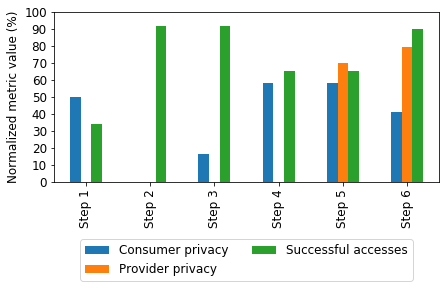

In [8]:
## Chart with all the data together

plt.rcParams.update({'font.size': 12})

col_chart_privacy_usefulness(
['reports/NYCDemoIncremental/step1_padec_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step2_padec_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step3_padec_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step4_twokh_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step5_filter_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step6_demo_PADECPartyReport.txt'],
         ['Step 1',
          'Step 2',
          'Step 3',
          'Step 4',
          'Step 5',
          'Step 6'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


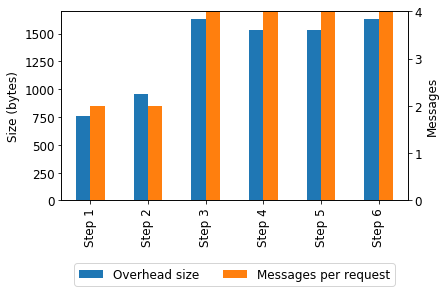

In [15]:
#col_chart_complexity(
#['reports/NYCDemoIncremental/step1_padec_demo_PADECPartyReport.txt',
#         'reports/NYCDemoIncremental/step2_padec_demo_PADECPartyReport.txt',
#         'reports/NYCDemoIncremental/step3_padec_demo_PADECPartyReport.txt',
#         'reports/NYCDemoIncremental/step4_twokh_demo_PADECPartyReport.txt',
#         'reports/NYCDemoIncremental/step5_filter_demo_PADECPartyReport.txt',
#         'reports/NYCDemoIncremental/step6_demo_PADECPartyReport.txt'],
#         ['Step 1',
#          'Step 2',
#          'Step 3',
#          'Step 4',
#          'Step 5',
#          'Step 6'])

col_chart_complexity_auto((0.98, -0.3))

In [2]:
## Table with normalized results (i.e. between 0 and 100)

generate_table(
        ['reports/NYCDemoIncremental/step1_padec_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step2_padec_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step3_padec_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step4_twokh_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step5_filter_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step6_demo_PADECPartyReport.txt'],
         ['Step 1',
          'Step 2',
          'Step 3',
          'Step 4',
          'Step 5',
          'Step 6'])

Step,Provider privacy,Consumer privacy,Denied accesses,Authorization request size,Messages per request
Step 1,0.0,0.0,65.57377049180327,33.333333333333336,50
Step 2,0.0,0.0,8.19672131147541,100.0,50
Step 3,0.0,0.0,8.19672131147541,66.66666666666667,100
Step 4,0.0,16.230717639168347,34.42622950819672,33.333333333333336,100
Step 5,70.19310344827586,16.230717639168347,34.42622950819672,33.333333333333336,100
Step 6,79.30909090909091,16.230717639168347,9.836065573770492,50.435949027498324,100


In [5]:
## Table with raw results

generate_table(
        ['reports/NYCDemoIncremental/step1_padec_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step2_padec_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step3_padec_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step4_twokh_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step5_filter_demo_PADECPartyReport.txt',
         'reports/NYCDemoIncremental/step6_demo_PADECPartyReport.txt'],
         ['Step 1',
          'Step 2',
          'Step 3',
          'Step 4',
          'Step 5',
          'Step 6'], normalize=False)

Step,Provider privacy,Consumer privacy,Denied accesses,Authorization request size,Messages per request
Step 1,0.0,0.0,40,1,2
Step 2,0.0,0.0,5,3,2
Step 3,0.0,0.0,5,2,4
Step 4,0.0,0.48692152917505016,21,1,4
Step 5,70.19310344827586,0.48692152917505016,21,1,4
Step 6,79.30909090909091,0.48692152917505016,6,1.5130784708249496,4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


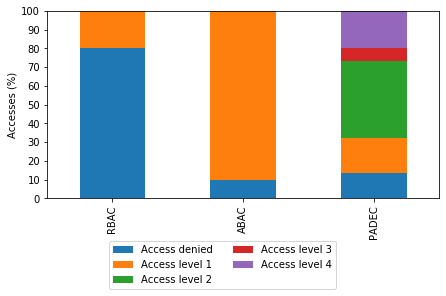

In [4]:
stacked_graph(
    ['reports/NYCDemoIncremental/step1_rbac_demo_PADECPartyReport.txt',
     'reports/NYCDemoIncremental/step3_abac_demo_PADECPartyReport.txt',
     'reports/Rainbow/rainbow_demo_PADECPartyReport.txt'], 
    ['RBAC',
     'ABAC',
     'PADEC'])

                  Metric Mechanism   Value
0  Contextual attributes      RBAC       1
1  Contextual attributes      ABAC       3
2  Contextual attributes     PADEC       3
3           Unique rules      RBAC      18
4           Unique rules      ABAC   49284
5           Unique rules     PADEC  146068
6   Unique access levels      RBAC       1
7   Unique access levels      ABAC       1
8   Unique access levels     PADEC  146068


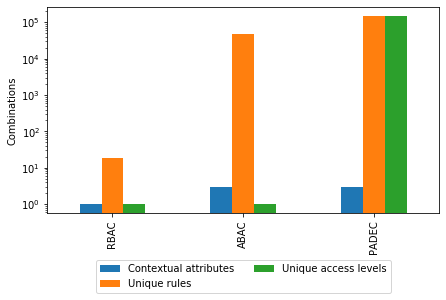

In [136]:
expressiveness_chart_combinating((0.5, -0.2))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


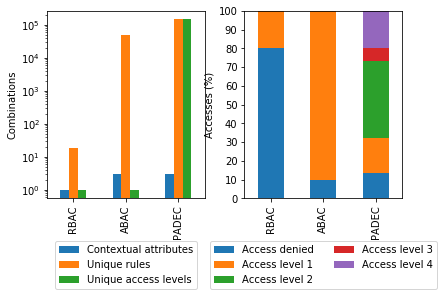

In [150]:
all_expr_charts(['reports/NYCDemoIncremental/step1_rbac_demo_PADECPartyReport.txt',
     'reports/NYCDemoIncremental/step3_abac_demo_PADECPartyReport.txt',
     'reports/Rainbow/rainbow_demo_PADECPartyReport.txt'], 
    ['RBAC',
     'ABAC',
     'PADEC'], (0.5, -0.2))

In [147]:
get_precisions('reports/NYCDemoIncremental/step5_filter_demo_PADECPartyReport.txt')

[-0.1, 100.0, 3.066666666666667]


C:\AnacondaEnvironment\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\AnacondaEnvironment\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\AnacondaEnvironment\lib\site-packages\networkx\drawing\nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


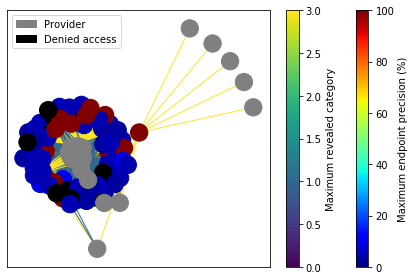

In [7]:
## Quick simulation sum-up graph for Step 6

draw_graph(read_report('reports/Rainbow/rainbow_demo_PADECPartyReport.txt'))